# Mid Semester Project - DEEP Reinforcements Learning
# ENV2 - KEY DOOR ENVIRONMENT
Dear students,<br> this is the template notebook. Please copy it by clicking on the "File" tab and then on "Save a copy into drive".

---
<br>

### Name and ID:
Student 1: Reut Dayan 206433245
<br>
Student 2: Yuval Saadaty 205956634
<br><br>
<img src="https://raw.githubusercontent.com/Farama-Foundation/Minigrid/master/minigrid-text.png">

### https://minigrid.farama.org/

# Pre-Requisit

## Installs

In [ ]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install gym
!pip install gym-minigrid
!pip install pygame
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install -U --no-cache-dir gdown --pre

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 Packages [27.8 kB]
Fetched 275 kB in 1s (219 kB/s)
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state 

## Imports

In [ ]:
import numpy as np
import gym
from gym import logger as gymlogger
from gym.utils import seeding
from gym import error, spaces, utils
gymlogger.set_level(40) # error only
import glob
import io
import base64
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2
import math
import glob
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pygame
import pyvirtualdisplay
import imageio
import IPython
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Display utils
The cell below contains the video display configuration. No need to make changes here.

In [ ]:

def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

#Env2 - Key Door Env

## Class Env

In [ ]:
# copy minigrid_x.py file from drive to colab
#import shutil

#from google.colab import drive
#drive.mount('/content/drive')

# Path to the file in Google Drive
#source_file_path = '/content/drive/MyDrive/minigrid_x.py'

# Destination path in the content directory of Colab
#destination_path = '/content/minigrid_x.py'

# Copy the file
#shutil.copyfile(source_file_path, destination_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/minigrid_x.py'

In [ ]:
from __future__ import annotations
from gym_minigrid.minigrid import COLOR_NAMES
from gym_minigrid.minigrid import Grid
from gym_minigrid.minigrid import MissionSpace
from gym_minigrid.minigrid import Door, Goal, Key, Wall, Lava, Floor
from minigrid_x import MiniGridEnv
from gym import spaces
import random

class RandomKeyMEnv_10(MiniGridEnv):
    def __init__(
        self,
        size=10,
        agent_start_pos=(1, 1), # aget allways starts at pos (1,1)
        agent_start_dir=0, # 0: right, 1: down, 2: left, 3: up
        max_steps: int | None = None,
        **kwargs,
    ):
        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir

        mission_space = MissionSpace(mission_func=self._gen_mission)

        if max_steps is None:
            max_steps = 4 * size**2

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            # Set this to True for maximum speed
            see_through_walls=True,
            max_steps=max_steps,
            **kwargs,
        )
        self.partition_col = 3
        self.walls_init = [(self.partition_col, i) for i in range(0, self.grid.height)]
        self.goal_pos = (self.grid.width - 2, self.grid.height - 2) # goal is always right buttom corner (8,8)
        self.open_door_once = False
        self.fixed_door_pos=None
        self.fixed_key_pos=None


    def get_pass_location(self):
      return (self.partition_col, self.pass_loc)

    def get_partition_column(self):
      return self.partition_col

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def get_k_pos(self):
      return self.key_pos

    def get_d_pos(self):
      return self.door_pos

    def _gen_grid(self, width, height):
        # Place Dor in random location within all column the partition
        self.pass_loc = random.choice([op_row for op_row in range(1, self.unwrapped.width-1)])

        # Create an empty grid
        self.grid = Grid(width, height)

        # Generate the surrounding walls
        self.grid.wall_rect(0, 0, width, height)

        # Generate verical separation wall
        # for i in range(0, height):
        #     self.grid.set(5, i, Wall())


        for column, row in self.walls_init:
          self.grid.set(column, row, Wall())

        # Place Key in random location within all the free spaces left to the partition
        if self.fixed_key_pos is not None:
            self.key_pos = self.fixed_key_pos
        else:
            self.key_pos = (random.choice([k_col for k_col in range(1,self.partition_col)]), random.choice([k_row for k_row in range(2,self.unwrapped.height-1)]))

        if self.fixed_door_pos is not None:
            self.door_pos = self.fixed_door_pos
        else:
          self.door_pos = (self.partition_col, self.pass_loc)

        self.env_door = Door(COLOR_NAMES[0], is_locked=True)

        # Place the Lava
        # self.grid.set(4, 6, Lava())

        # Place the door and key
        self.grid.set(self.door_pos[0], self.door_pos[1], self.env_door)
        self.grid.set(self.key_pos[0], self.key_pos[1], Key(COLOR_NAMES[0]))
        self.goal_pos = (width - 2, height - 2)
        # Place a goal square in the bottom-right corner
        self.put_obj(Goal(), self.goal_pos[0], self.goal_pos[1])

        # Place the agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

        self.mission = "grand mission"

    def is_carrying_key(self):
        if 'Key' in str(self.unwrapped.carrying):
            return True
        return False

    def is_door_open(self):
        return self.unwrapped.env_door.is_open

    def is_open_door_once(self):
        return self.unwrapped.open_door_once

    def is_wall_front_pos(self):
      if 0 in self.unwrapped.front_pos or (self.unwrapped.height-1) in self.unwrapped.front_pos:
        return True
      return (tuple(self.unwrapped.front_pos) in self.unwrapped.walls_init)

    def is_door_front_pos(self):
      return (tuple(self.unwrapped.front_pos) == self.unwrapped.get_d_pos())

    def is_key_front_pos(self):
      return (tuple(self.unwrapped.front_pos) == self.unwrapped.get_k_pos())



## WRAPPER

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

ACTION_MAP = {0:0, #trurn left
              1:1, #turn right
              2:2, #srep forward
              3:3, #take key
              4:5} #open door


class KEYRGBImgObsWrapper(gym.core.ObservationWrapper):
    """
    Wrapper to use fully observable RGB image as the only observation output,
    no language/mission. This can be used to have the agent to solve the
    gridworld in pixel space.
    """

    def __init__(self, env, tile_size=32, plot=False, preprocess= lambda x: x):
        super().__init__(env)

        self.tile_size = tile_size
        self.plot = plot
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            # #the default is (320,320,3). Tile size  = 32 X 10 (grid size)
            # TODO: BE CAREFULL TO CHANGE the shape size to be according your preprocess size/channels
            # The env information i staken from here
            shape=(320, 320, 3),
            dtype='uint8'
        )
        self.prev_door = False
        self.prev_key = False
        self.action_space = spaces.Discrete(self.action_space.n - 2)

        self._preprocess = self.preprocess_image


    def preprocess_image(self, image):
      image = image.transpose(2,0,1)
      # Convert ndarray to PIL Image
      image_pil = Image.fromarray(image.transpose((1, 2, 0)))  # Assuming 'image' is a ndarray with shape (3, 320, 320)

      # Define transformations to be applied to the images - dataset preprocess
      transform = transforms.Compose([
          transforms.Resize((200, 200)),       # Resize the image to 110*110
          transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
          transforms.CenterCrop((160, 160)),  # Crop the center 84*84 portion of the image
          transforms.ToTensor(),              # Convert the image to a PyTorch tensor and maps [0,255] to [0,1]
          ])

      # Apply the transformation
      transformed_image = transform(image_pil)

      return transformed_image

    def observation(self, obs):
      env = self.unwrapped

      # Call render without any unsupported keyword arguments
      rgb_img = env.render()  # Use the default rendering behavior
      return rgb_img

    def reset(self, seed = 0, options = None):
        self.prev_door = False
        self.prev_key = False
        obs, info = super().reset()
        if self.plot:
            plt.show()
        return self._preprocess(obs), info

    def step(self, action):

        env = self.unwrapped
        # Get the position in front of the agent
        fwd_pos = env.front_pos
        # Get the contents of the cell in front of the agent
        fwd_cell = env.grid.get(*fwd_pos)

        # Rotate left
        if action == 0:
            if self.is_door_open():
                reward = -20
            else:
              reward =-7

        # Rotate right
        elif action == 1:
            if self.is_door_front_pos():
              reward = -20
            elif self.agent_pos[1] == self.door_pos[1]  and (self.door_pos[0]-self.agent_pos[0] ==1) and env.agent_dir !=0 and not self.is_door_open():
              reward = 2
            else:
               reward =-1

        # Move forward
        elif action == 2:
            if self.is_wall_front_pos() and not self.is_door_front_pos() :
              reward = -100
            elif self.door_pos == self.agent_pos and self.is_door_open() or (self.is_door_front_pos() and self.is_door_open()):
              reward = 20
            elif fwd_cell and fwd_cell.can_pickup() and not self.is_carrying_key(): # the door is close and agent is in front of the door
              reward = -20
            elif self.is_door_front_pos() and not self.is_door_open():
               reward = -20
            elif self.is_door_open():
               reward = 7
            else :
               reward = 5


        # Pick up an object
        elif action == 3:
          if fwd_cell and fwd_cell.can_pickup():
            if not self.is_carrying_key():
              reward = 100
            else:
              reward = -20
          else:
            reward = -50


        # Toggle/activate an object
        elif action == 4:
            if fwd_cell:
              if self.is_carrying_key() and not self.is_door_open() and  self.is_door_front_pos():
                  reward = 100
              else:
                  reward =-200
            else:
              reward = -20

        else:
            reward = -1
            raise ValueError(f"Unknown action: {action}")

        action = ACTION_MAP[action]
        obs, r, d, info, x = super().step(action)
        obs = self._preprocess(obs)
        if d:
          r = 10000 # 200 for done
        else:
          r= reward

        return obs, r, d, info, x


## Env Info

torch.Size([1, 160, 160])


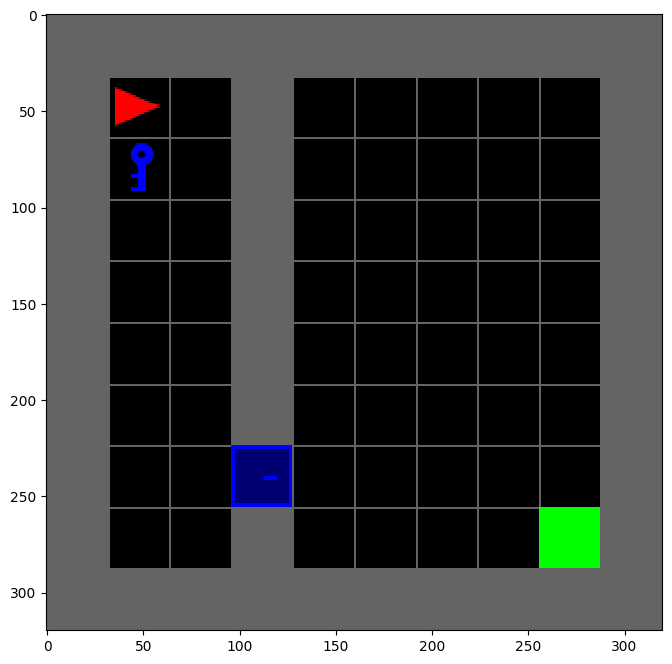

In [ ]:
env = KEYRGBImgObsWrapper(RandomKeyMEnv_10 (render_mode='rgb_array'))
obs = env.reset()[0]
print(obs.shape)
screen = env.render()
plt.imshow(screen)

False
5


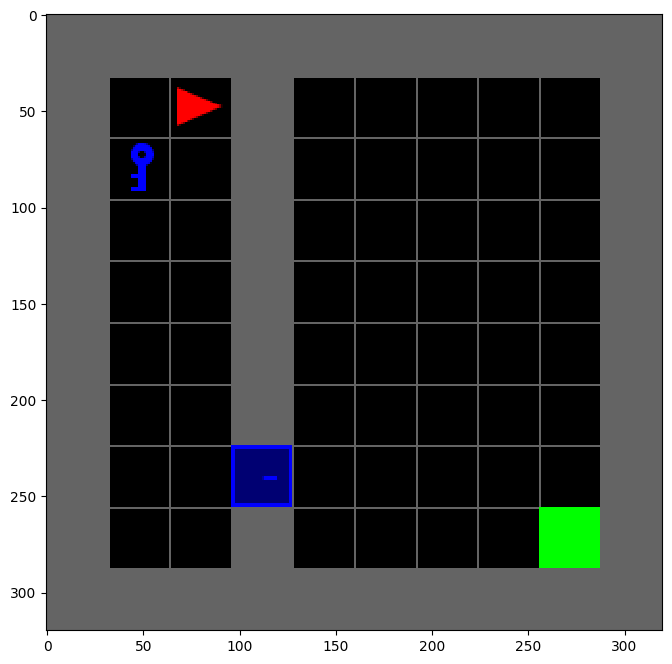

In [ ]:
obs, r, d, info, x = env.step(2
)
print(env.is_door_open())
print(r)
screen = env.render()
plt.imshow(screen)

## Random action

In [ ]:
env = KEYRGBImgObsWrapper(RandomKeyMEnv_10 (render_mode='rgb_array'))
obs = env.reset()
video_filename = '/content/vid.mp4'
max_steps = 100
# Evaluation
with imageio.get_writer(video_filename, fps=10) as video:
  obs = env.reset()
  done = False
  total_reward = 0
  for step in range(max_steps):
      action = env.action_space.sample()
      obs, reward, done, _, _ = env.step(action)
      next_obs = obs  # Get agent's position directly from the environment
      video.append_data(env.render())
      if done:
        print("done","reward=", total_reward,"num_of_steps=",step)
        break
embed_mp4(video_filename)

## DQN



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2),   # (84-3+1)/2 = 41, 1*84*84-> 16*41*41
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2), # (41-4+1)/2 = 19 16*41*41->32*19*19
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2), # (19-4+1)/2 = 8 32*18*19 -> 64*8*8
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2), # (8-3+1)/2 = 3 64*8*8 -> 128*3*3
            nn.ReLU()
        )
        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(torch.prod(torch.tensor(o.size())))

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [ ]:
from collections import deque, namedtuple

class ReplayBuffer:
    def __init__(self, buffer_size):
      self.memory = deque(maxlen=buffer_size)
      self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])


    def add(self, state, action, reward, next_state, done):
      # add experience to replay memory
      e = self.experience(state, action, reward, next_state, done)
      self.memory.append(e)

    def sample(self, batch_size):
      # get random minibatch from memory
      experiences = random.sample(self.memory, k=batch_size)

      # stack all non none states
      states = torch.stack([e.state for e in experiences])
      actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
      rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
      next_states = torch.from_numpy(np.stack([e.next_state for e in experiences if e is not None])).to(device)
      dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

      return (states, actions, rewards, next_states, dones)

    def __len__(self):
      # Return the current size of the replay memory
      return len(self.memory)

In [ ]:
obs = env.reset()[0]
state_size = obs.shape
action_space = env.action_space
num_actions = action_space.n
print(f"Number of actions: {num_actions}")
print(f"State size is: {state_size}")

Number of actions: 5
State size is: torch.Size([1, 160, 160])


In [ ]:
BUFFER_SIZE =    10000
BATCH_SIZE         =    32       # minibatch size
GAMMA              =    0.99     # discount factor
SOFT_UPDATE_RATE   =    1e-3     # for soft update of target parameters
LEARNING_RATE      =    1e-4     # learning rate
UPDATE_EVERY       =    5       # how often to update the network
n_episodes=10000                 #number of episodes - reset the game
max_t=1000                        #maximum number of timesteps per episode
eps_start=1.0
eps_end=0.01
eps_decay=0.995

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# initialize networks
policy_network = DQN(state_size, action_space.n).to(device)
target_network = DQN(state_size, action_space.n).to(device)
memory = ReplayBuffer(buffer_size=BUFFER_SIZE)
optimizer = optim.Adam(policy_network.parameters(), lr = LEARNING_RATE)

In [ ]:
def epsilon_gredy(state, eps, n_actions):
  policy_network.eval()
  with torch.no_grad():
    # Epsilon-greedy action selection
    if random.random() > eps:
       #Forward step
      action_values = policy_network(state.unsqueeze(0))     # calculate the policy network approximation to q vals
      action =  np.argmax(action_values.cpu().data.numpy()) # action that maximaize the q value
    else:
      action = random.choice(np.arange(n_actions)) # random action

    #training mode.
    policy_network.train()
    return action

In [ ]:
def learn(batch_size):
  # If enough samples are available in memory, get random subset and learn
  if len(memory) >= batch_size:
    # sample minibatch of experiences
    states, actions, rewards, next_states, dones = memory.sample(batch_size)
    # compute approximation on the target network
    targets_next = target_network(next_states).detach().max(1)[0].unsqueeze(1) # (64,1)

    # Calculate target value from bellman equation
    q_targets = rewards + GAMMA * targets_next * (1 - dones)
    q_expected = policy_network(states).gather(1, actions) # policy_network(state).shape = (B,3) - we gather (1, actions) to index the q-values of selected actions by policy

    ### Loss calculation (we used Mean squared error)
    loss = F.mse_loss(q_expected, q_targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
def copy_weights(t_step):
  # Learn every UPDATE_EVERY time steps.
  if t_step == 0:
    if len(memory) > BATCH_SIZE:
      for target_param, local_param in zip(target_network.parameters(), policy_network.parameters()):
        target_param.data.copy_(SOFT_UPDATE_RATE*local_param.data + (1.0-SOFT_UPDATE_RATE)*target_param.data)

In [ ]:
env = KEYRGBImgObsWrapper(RandomKeyMEnv_10 (render_mode='rgb_array'))
scores = []
eps = eps_start                    # initialize epsilon
t_step = 0
l_step = 0
n_episodes_for_val = 10
LEARN_EVERY = 5
n_dones = 0
is_done = False
for i_episode in range(1, n_episodes+1): # number of episodes
  state, _ = env.reset()                 # reset new game
  state = state.to(device)
  score = 0
  for t in range(max_t):
    # Epsilon-greedy action selection
    action = epsilon_gredy(state, eps, env.action_space.n)

    # Step
    next_state, reward, done, _, _ = env.step(action)

    # Add experience to memory
    memory.add(state.clone(), action, reward, next_state.clone(), done)

    next_state = next_state.to(device)
    state=next_state
    l_step = (l_step+1) % LEARN_EVERY
    if l_step == 0:
      learn(batch_size=BATCH_SIZE)

    # Learn every UPDATE_EVERY time steps.
    t_step = (t_step+1) % UPDATE_EVERY
    copy_weights(t_step)
    score += reward
    if done:
      is_done = True
      n_dones += 1
      break
  eps = max(eps_end, eps_decay*eps) # decrease epsilon

  scores.append(score) # save most recent score

  print('\rEpisode {}\t Score: {:.2f} \t done={}'.format(i_episode, score, is_done), end="")
  is_done = False
  if i_episode % 100 == 0:
    print('\rEpisode {}\t Avarage Score: {:.2f}'.format(i_episode, np.mean(scores[-100:])))
    n_dones =0

Episode 100	 Avarage Score: -21348.62
Episode 200	 Avarage Score: -13141.60
Episode 300	 Avarage Score: -3766.30
Episode 400	 Avarage Score: -12106.80
Episode 500	 Avarage Score: -29794.56
Episode 600	 Avarage Score: -24650.36
Episode 700	 Avarage Score: -24505.78
Episode 800	 Avarage Score: -20702.99
Episode 900	 Avarage Score: -19055.43
Episode 1000	 Avarage Score: -11932.22
Episode 1100	 Avarage Score: -11832.51
Episode 1200	 Avarage Score: -6288.64
Episode 1300	 Avarage Score: 932.56
Episode 1400	 Avarage Score: 1621.04
Episode 1500	 Avarage Score: 4505.81
Episode 1600	 Avarage Score: 5356.82
Episode 1700	 Avarage Score: 8110.94
Episode 1800	 Avarage Score: 6884.66
Episode 1900	 Avarage Score: 10034.26
Episode 2000	 Avarage Score: 10198.51
Episode 2100	 Avarage Score: 9769.63
Episode 2200	 Avarage Score: 10120.62
Episode 2300	 Avarage Score: 9360.56
Episode 2400	 Avarage Score: 10085.22
Episode 2500	 Avarage Score: 10237.28
Episode 2600	 Avarage Score: 10215.75
Episode 2700	 Avarag

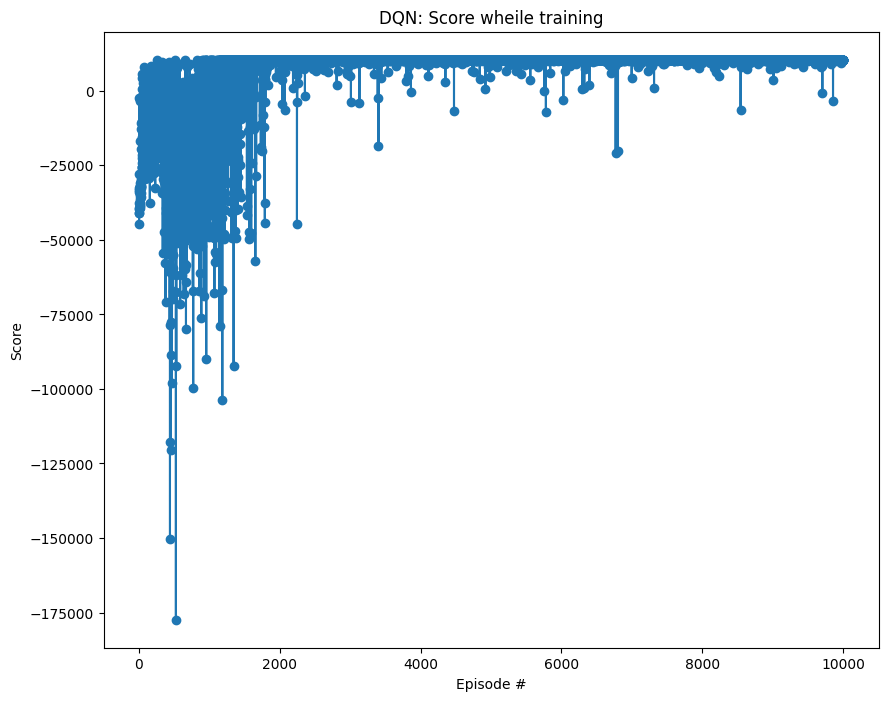

In [ ]:
# plot the scores
plt.plot(np.arange(1, len(scores)+1), scores, marker='o')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('DQN: Score wheile training')
plt.show()

In [ ]:
torch.save(policy_network.state_dict(), '/content/drive/My Drive/policy_key_door_dqn_model_weights.pth')
torch.save(target_network.state_dict(), '/content/drive/My Drive/target_key_door_dqn_model_weights.pth')

In [ ]:
from tqdm import tqdm

env = KEYRGBImgObsWrapper(RandomKeyMEnv_10 (render_mode='rgb_array'))
video_filename = '/content/vid.mp4'
max_steps = 100
# Evaluation
with imageio.get_writer(video_filename, fps=10) as video:
  obs = env.reset()[0]
  done = False
  total_reward = 0
  obs = obs.to(device)
  for step in tqdm(range(max_steps)):
    action = policy_network(obs.unsqueeze(0)).max(1)[1].item()
    new_obs, reward, done, _, _ = env.step(action)
    new_obs = new_obs.to(device)
    total_reward += reward
    video.append_data(env.render())
    obs = new_obs
    if done:
      print("done","reward=", total_reward,"num_of_steps=",step)
      break
embed_mp4(video_filename)

 21%|██        | 21/100 [00:00<00:02, 33.76it/s]

done reward= 10289 num_of_steps= 21


In [ ]:
num_episodes = 100
steps_per_episode = []
rewards_per_episode = []
env = KEYRGBImgObsWrapper(RandomKeyMEnv_10(render_mode='rgb_array'))
max_steps = 100

# Run the episodes
for episode in range(num_episodes):
    obs = env.reset()[0]
    done = False
    total_reward = 0
    obs = obs.to(device)

    for step in range(max_steps):
        action = policy_network(obs.unsqueeze(0)).max(1)[1].item()
        new_obs, reward, done, _, _ = env.step(action)
        new_obs = new_obs.to(device)
        total_reward += reward
        obs = new_obs
        if done:
            steps_per_episode.append(step)
            rewards_per_episode.append(total_reward)
            break

# Calculate average number of steps
average_steps = np.mean(steps_per_episode)
print("Average number of steps:", average_steps)

# Calculate average reward
average_reward = np.mean(rewards_per_episode)
print("Average reward:", average_reward)


Average number of steps: 22.632653061224488
Average reward: 10293.80612244898


In [ ]:
model =  DQN(state_size, action_space.n).to(device)
model.load_state_dict(torch.load('/content/drive/My Drive/key_door_dqn_model_weights.pth'))

